## Processing Shalem 2014
- Processing GeckoV1 screen from [Shalem 2014](https://science.sciencemag.org/content/343/6166/84)
- A375
- Library design: sgRNAs were ranked by an off target
score using a metric that includes the number of off-targets in the genome and the type of
mutations (distance from protospacer-adjacent motif and clustering of mismatches) and those
with lowest off-target scores were selected. This resulted in a library in which most genes have
an average of 3 or 4 sgRNAs.

### Data Filters
1. pdna or etp > mean pdna -3 std
2. sgRNAs targetting essential genes
3. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot
from poola import core as pool

In [2]:
lognorms = pd.read_table('../data/raw/Shalem2014_GeCKOv1_lognorms.txt')
essential_genes = pd.read_table('https://raw.githubusercontent.com/hart-lab/bagel/master/CEGv2.txt')
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/hart-lab/bagel/master/NEGv1.txt')

In [3]:
clean_lognorms = (lognorms.drop(['PLXRep1', 'PLXRep2', 'PLXRep3', 'PLXRep4', 
                                 'DMSO-ETP 1', 'DMSO-ETP 2'], axis=1)
                  .rename({'DMSORep1': 'A375_Rep1', 'DMSORep2': 'A375_Rep2'}, axis=1))
filtered_lognorms = pool.filter_pdna(lognorm_df=clean_lognorms, pdna_cols=['ETP'])
print('Filtered ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')

Filtered 170 columns due to low pDNA abundance


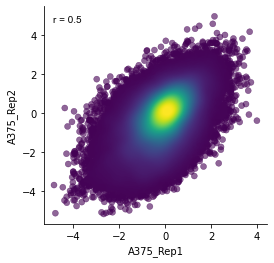

In [4]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='ETP', target_cols=['A375_Rep1', 'A375_Rep2'])
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_df, x='A375_Rep1', y='A375_Rep2')
gpplot.add_correlation(data=lfc_df, x='A375_Rep1', y='A375_Rep2')
sns.despine()

In [5]:
avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=lfc_df, guide_col='Sequence', condition_indices=[0], 
                                                   lfc_cols=['A375_Rep1', 'A375_Rep2'], sep='_')

In [6]:
sg_list = list(avg_replicate_lfc_df['Sequence'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [7]:
lfcs_designs = (avg_replicate_lfc_df.rename({'Sequence': 'sgRNA Sequence'}, axis=1)
                .merge(design_df, how = 'inner', on = 'sgRNA Sequence'))
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.GENE,
                                fp_genes=nonessential_genes.GENE, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
roc_aucs

,condition,ROC-AUC
0,A375,0.78011


We'll filter for genes that have at least 3 guides

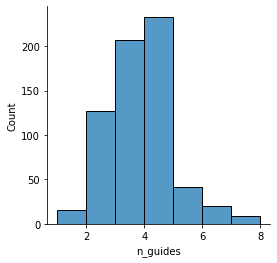

In [8]:
ess_lfcs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(essential_genes.GENE)]
essential_gene_count = (ess_lfcs['Target Gene Symbol'].value_counts()
                        .reset_index(name='n_guides')
                        .rename({'index': 'gene'}, axis=1))
plt.subplots(figsize=(4,4))
sns.histplot(essential_gene_count['n_guides'], binwidth=1)
sns.despine()

In [9]:
relevant_essential_genes = essential_gene_count.gene[essential_gene_count.n_guides >= 3]
filtered_ess_lfcs = ess_lfcs[ess_lfcs['Target Gene Symbol'].isin(relevant_essential_genes)]

In [10]:
filtered_sgs = filtered_ess_lfcs[(filtered_ess_lfcs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
print('Off target filtered: ' + str(filtered_ess_lfcs.shape[0] - filtered_sgs.shape[0]))

Off target filtered: 69


In [11]:
filtered_sgs['mean_centered_neg_lfc'] = (filtered_sgs.groupby(['Target Gene Symbol'])
                                         .avg_lfc
                                         .transform(lambda x: -(x - x.mean())))
filtered_sgs = filtered_sgs[['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                             'Target Cut %', 'On-Target Efficacy Score', 'mean_centered_neg_lfc']]

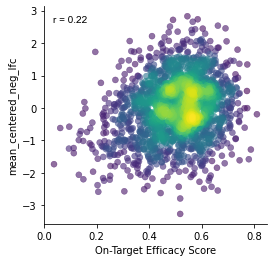

In [12]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=filtered_sgs, x='On-Target Efficacy Score', y='mean_centered_neg_lfc')
gpplot.add_correlation(data=filtered_sgs, x='On-Target Efficacy Score', y='mean_centered_neg_lfc', method='pearson')
sns.despine()

## Output

In [13]:
output_df = filtered_sgs.drop('On-Target Efficacy Score', axis=1)
output_df

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,mean_centered_neg_lfc
23,AAAAAGAAGAGTTTCTCCAG,TGTCAAAAAGAAGAGTTTCTCCAGAGGAAG,EIF2S1,28.9,-1.634336
24,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AQR,3.8,0.610029
102,AAAACTGGCACGACCATCGC,CCGGAAAACTGGCACGACCATCGCTGGGGT,PSMB7,16.4,1.736252
114,AAAAGAACCTGCTAGTTACT,CGAGAAAAGAACCTGCTAGTTACTAGGTAA,WDR3,17.5,0.567289
120,AAAAGACCACGAGAAGATCA,TGTTAAAAGACCACGAGAAGATCATGGCCG,HNRNPU,28.8,2.425504
...,...,...,...,...,...
65099,TTTTGCAGTTATTTATCTTG,AAAATTTTGCAGTTATTTATCTTGTGGATA,TXNL4A,41.5,-0.403913
65134,TTTTTACAGCAAGATGGAAT,TAATTTTTTACAGCAAGATGGAATTGGGGA,PSMC3,6.3,-1.638811
65146,TTTTTATAGTTGAACGCATG,TTGTTTTTTATAGTTGAACGCATGAGGAAT,DDX21,38.8,-0.872235
65170,TTTTTCTAGACTACTGGACT,TATCTTTTTCTAGACTACTGGACTTGGAGG,COX11,45.0,-0.551121


In [14]:
output_df.to_csv('../data/processed/Shalem2014_activity.csv', index=False)